In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
data_train = pd.read_csv('train.csv')
data_testA = pd.read_csv('testA.csv')

In [3]:
cat_features = list(data_train.select_dtypes(include=['object', 'category']).columns)
num_features = list(data_train.select_dtypes(include=['int64', 'float64']).columns)

In [4]:
cat_features

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [5]:
num_features

['id',
 'loanAmnt',
 'term',
 'interestRate',
 'installment',
 'employmentTitle',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'isDefault',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14']

In [6]:
num_features.remove('isDefault')

In [7]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

<details>
<summary><h2> 📌 Why test set must be filled using training statistics (Click to expand)</h2></summary>

<br/>

### ✅ Core Principle

> The test set should only be *used*, never *learned from*.  
> Any statistics or transformations must be derived solely from the training data.

---

### 🎯 Why fill test set missing values with training statistics?

We must fill missing values in the test set using **statistics from the training set** (e.g., median, mean, or mode), **not** the test set itself. Here's why:

---

### ✅ 1. To Prevent Data Leakage

Using `data_test[col].median()` lets the model **peek into test distribution** — something it would never know in real deployment.

This causes **data leakage**, inflating performance and damaging generalization.

---

### ✅ 2. To Ensure Fair Evaluation and Generalization

We simulate reality:
> “We only use past data to prepare for future inputs.”

This ensures your model is evaluated under realistic deployment conditions.

---

### 🔍 Example:

| Dataset      | Median of `loanAmnt` |
|--------------|----------------------|
| Training set | \$10,000             |
| Test set     | \$25,000             |

Using the test median leaks test distribution knowledge into the model → unfair advantage → poor real-world performance.

---

### ✅ Best Practices: Fit on Train, Transform on Test

| Step                         | Use Training Set Only |
|------------------------------|------------------------|
| Missing value imputation     | ✅ Yes                 |
| Normalization / Standardization | ✅ Yes             |
| One-Hot / Label Encoding     | ✅ Yes                 |
| PCA / Feature transformation | ✅ Yes (fit once)      |
| Test set application         | ❌ Never fit on test   |

---

### 🧠 Rule of Thumb

> **Fit on train, transform on test.**  
A fundamental rule in machine learning pipelines.

---

### ✅ Summary

> ❗️The test set must be *used*, not *learned from*.  
> ✅ Always apply training-derived parameters when preprocessing the test set.

</details>

In [8]:
# Fill missing values in train and test sets
#  Numerical features: fill with median from training data
#  Categorical features: fill with mode from

fill_values = {}

# Numerical
for col in num_features:
    median_val = data_train[col].median()
    fill_values[col] = median_val
    data_train[col].fillna(median_val, inplace=True)
    data_testA[col].fillna(median_val, inplace=True)

# Category
for col in cat_features:
    mode_val = data_train[col].mode()[0]
    fill_values[col] = mode_val
    data_train[col].fillna(mode_val, inplace=True)
    data_testA[col].fillna(mode_val, inplace=True)

print("Missing value fill mapping:")
for col, val in fill_values.items():
    print(f"{col}: {val}")

Missing value fill mapping:
id: 399999.5
loanAmnt: 12000.0
term: 3.0
interestRate: 12.74
installment: 375.135
employmentTitle: 7755.0
homeOwnership: 1.0
annualIncome: 65000.0
verificationStatus: 1.0
purpose: 0.0
postCode: 203.0
regionCode: 14.0
dti: 17.61
delinquency_2years: 0.0
ficoRangeLow: 690.0
ficoRangeHigh: 694.0
openAcc: 11.0
pubRec: 0.0
pubRecBankruptcies: 0.0
revolBal: 11132.0
revolUtil: 52.1
totalAcc: 23.0
initialListStatus: 0.0
applicationType: 0.0
title: 1.0
policyCode: 1.0
n0: 0.0
n1: 3.0
n2: 5.0
n3: 5.0
n4: 4.0
n5: 7.0
n6: 7.0
n7: 7.0
n8: 13.0
n9: 5.0
n10: 11.0
n11: 0.0
n12: 0.0
n13: 0.0
n14: 2.0
grade: B
subGrade: C1
employmentLength: 10+ years
issueDate: 2016-03-01
earliesCreditLine: Aug-2001


In [9]:
# Convert issueDate to datetime format
data_train['issueDate'] = pd.to_datetime(data_train['issueDate'], format="%Y-%m-%d")
data_testA['issueDate'] = pd.to_datetime(data_testA['issueDate'], format="%Y-%m-%d")

base_date = datetime.strptime('2007-06-01', '%Y-%m-%d')

# Create numerical date feature(days since base_date)
data_train['issueDateDT'] = (data_train['issueDate'] - base_date).dt.days
data_testA['issueDateDT'] = (data_testA['issueDate'] - base_date).dt.days

In [10]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

employmentLength
1 year        52489
10+ years    309552
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
Name: count, dtype: int64

In [11]:
def employment_length_to_int(s):
    if pd.isnull(s):
        return np.nan
    # Remove leading and trailing whitespace
    s = s.strip()
    if s == '< 1 year':
        return 0
    elif s == '10+ years':
        return 10
    else:
        try:
            return int(s.split()[0])
        except Exception:
            return np.nan

for df in [data_train, data_testA]:
    df['employmentLength'] = df['employmentLength'].astype(str).str.strip()
    df['employmentLength'] = df['employmentLength'].apply(employment_length_to_int)

In [12]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

employmentLength
0      64237
1      52489
2      72358
3      64152
4      47985
5      50102
6      37254
7      35407
8      36192
9      30272
10    309552
Name: count, dtype: int64

In [13]:
data_train['earliesCreditLine'].sample(10)

435004    Sep-2003
444219    Oct-1999
590133    Apr-1985
113772    Jan-2005
731695    May-2005
648424    Aug-1996
695453    Mar-1999
636882    Apr-2001
82825     May-2007
664636    Mar-2002
Name: earliesCreditLine, dtype: object

In [14]:
import re
def extract_year_from_string(s):
    current_year = 2025
    if pd.isnull(s):
        return np.nan
    s = str(s).strip()

    # try to extract a 4-digit number that looks like a year
    match = re.search(r'(\d{4})', s)
    if match:
        year = int(match.group(1))
        if 1900 <= year <= current_year:
            return year
    return np.nan

for df in [data_train, data_testA]:
    df['earliesCreditLine'] = df['earliesCreditLine'].apply(extract_year_from_string)

In [15]:
data_train['earliesCreditLine'].sample(10)

168655    1999
204335    1999
293605    1977
564850    2001
431961    2005
358875    2005
48893     2006
711299    2000
415754    1995
20467     2004
Name: earliesCreditLine, dtype: int64

In [16]:
cat_features_edit = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose',
                     'postCode', 'applicationType', 'initialListStatus']

for col in cat_features_edit:
    unique_count = data_train[col].nunique()
    print(f"{col:<20} -> Unique categories: {unique_count}")

grade                -> Unique categories: 7
subGrade             -> Unique categories: 35
employmentTitle      -> Unique categories: 248683
homeOwnership        -> Unique categories: 6
verificationStatus   -> Unique categories: 3
purpose              -> Unique categories: 14
postCode             -> Unique categories: 932
applicationType      -> Unique categories: 2
initialListStatus    -> Unique categories: 2


In [17]:
# Map 'grade' (ordered categories) to integer values: A=1...
for df in [data_train, data_testA]:
    df['grade'] = df['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

for i, df in enumerate([data_train, data_testA]):
    df_encoded = pd.get_dummies(df, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'])
    if i == 0:
        data_train = df_encoded
    else:
        data_testA = df_encoded

In [18]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'employmentTitle', 'employmentLength', 'annualIncome', 'issueDate',
       ...
       'regionCode_41', 'regionCode_42', 'regionCode_43', 'regionCode_44',
       'regionCode_45', 'regionCode_46', 'regionCode_47', 'regionCode_48',
       'regionCode_49', 'regionCode_50'],
      dtype='object', length=152)

In [19]:
data_testA.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'employmentTitle', 'employmentLength', 'annualIncome', 'issueDate',
       ...
       'regionCode_41', 'regionCode_42', 'regionCode_43', 'regionCode_44',
       'regionCode_45', 'regionCode_46', 'regionCode_47', 'regionCode_48',
       'regionCode_49', 'regionCode_50'],
      dtype='object', length=151)

In [20]:
# Ensure the train and test sets have the same columns
data_train, data_testA = data_train.align(data_testA, join='left', axis=1, fill_value=0)

In [21]:
data_testA.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'employmentTitle', 'employmentLength', 'annualIncome', 'issueDate',
       ...
       'regionCode_41', 'regionCode_42', 'regionCode_43', 'regionCode_44',
       'regionCode_45', 'regionCode_46', 'regionCode_47', 'regionCode_48',
       'regionCode_49', 'regionCode_50'],
      dtype='object', length=152)

## Handling of Outliers

In [25]:
def find_outliers(df, columns, method='iqr', sigma_threshold=3, iqr_multiplier=1.5):
    """
    Detect outliers in a numerical feature using IQR or 3-sigma rule.

    Paremeters:
        df (pd.DataFrame): Dataset to process
        columns (list): Columns to check
        method (str):'iqr' or 'sigma' (default: 'iqr')
        sigma_threshold (float): std multiplier for sigma method
        iqr_mutiplier (float): IQR multiplier for IQR method

    Returns:
        result_df (pd.DataFrame): original df + outlier flags
        summary_df (pd.DataFrame): summary of outlier counts and ratios
    """
    result_df = df.copy()
    summary = []

    for col in columns:
        if method == 'sigma':
            mean = result_df[col].mean()
            std = result_df[col].std()
            lower, upper = mean - sigma_threshold * std, mean + sigma_threshold * std
        elif method == 'iqr':
            Q1 = result_df[col].quantile(0.25)
            Q3 = result_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - iqr_multiplier * IQR
            upper = Q3 + iqr_multiplier * IQR
        else:
            raise ValueError("method must bt 'iqr' or 'sigma'")
        flag_col = f"{col}_outlier_flag"
        result_df[flag_col] = ((result_df[col] < lower) | (result_df[col] > upper)).astype(int)
        summary.append({
            'feature': col,
            'outlier': result_df[flag_col].sum(),
            'total': result_df.shape[0],
            'outlier_ratio':result_df[flag_col].mean()
        })

    summary_df = pd.DataFrame(summary)
    return result_df, summary_df

In [23]:
for fea in cat_features_edit:
    if fea in num_features:
        num_features.remove(fea)
num_features.remove('regionCode')

In [26]:
result_df = pd.DataFrame()
summary_df = pd.DataFrame()
result_df, summary_df = find_outliers(data_train, num_features)

In [27]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'employmentTitle', 'employmentLength', 'annualIncome', 'issueDate',
       ...
       'regionCode_41', 'regionCode_42', 'regionCode_43', 'regionCode_44',
       'regionCode_45', 'regionCode_46', 'regionCode_47', 'regionCode_48',
       'regionCode_49', 'regionCode_50'],
      dtype='object', length=152)

In [28]:
summary_df

,feature,outlier,total,outlier_ratio
0,id,0,800000,0.000000
1,loanAmnt,4246,800000,0.005307
2,term,193098,800000,0.241372
3,interestRate,14803,800000,0.018504
4,installment,24992,800000,0.031240
5,annualIncome,39014,800000,0.048767
6,dti,3271,800000,0.004089
7,delinquency_2years,154285,800000,0.192856
8,ficoRangeLow,27667,800000,0.034584
9,ficoRangeHigh,27667,800000,0.034584


In [29]:
result_df, summary_df = find_outliers(data_train, num_features, method='sigma')

In [30]:
summary_df

,feature,outlier,total,outlier_ratio
0,id,0,800000,0.000000
1,loanAmnt,0,800000,0.000000
2,term,0,800000,0.000000
3,interestRate,5741,800000,0.007176
4,installment,7954,800000,0.009942
5,annualIncome,6027,800000,0.007534
6,dti,1560,800000,0.001950
7,delinquency_2years,21755,800000,0.027194
8,ficoRangeLow,11739,800000,0.014674
9,ficoRangeHigh,11739,800000,0.014674


In [31]:
def process_outliers_batch(df, cols, methon='iqr', strategy='clip', keep_flag=True, 
                           sigma_threshold=3, iqr_mutiplier=0.15, clip_percentile=(0.01, 0.99)):
    """
    Batch detect and process outliers for multiple numeric columns using IQR or 3-sigma rule.

    Paremeters:
        df (pd.DataFrame): Input DataFrame
        cols (list of str): List of column names to process
        method (str): Processing method:
                      - 'clip': clip values to percentile range
                      - 'log1p': apply log1p transformation
        keep_flag (bool): Whether to create <col>_is_outlier flag columns
        sigma_threshold (float): Std multiplier for 'sigma' method
        iqr_multiplier (float): IQR multiplier for 'iqr' method
        clip_percentile (tuple): (lower, upper) percentile for clipping

        Returns:
            pd.DataFrame: A new DataFrame with processed columns and optional outlier flags

    """
    df_new = df.copy()

    for col in cols:
        # Calculate outlier bounds
        if method == 'iqr':
            Q1 = df_new[col].quantile(0.25)
            Q3 = df_new[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - iqr_mutiplier * IQR
            upper = Q3 + iqr_mutiplier * IQR
        elif method == 'sigma':
            mean = df_new[col].mean()
            std = df_new[col].std()
            lower = mean - sigma_threshold * std
            upper = mean + sigma_threshold * std
        else:
            raise ValueException("method must be 'iqr' or 'sigma'")

        # optional: create outlier flag
        if keep_flag:
            df_new[f"{col}_is_outlier"] = ((df_new[col] < lower) | (df_new[col] > upper))

        # Apply processing strategy
        if strategy == 'clip':
            low_val = df_new[col].quantile(clip_percentile[0])
            high_val = df_new[col].quantile(clip_percentile[1])
            df_new[f"{col}_processed"] = df_new[col].clip(lower=low_val, upper=high_val)
        elif strategy == 'log1p':
            df_new[f"{col}_processed"] = np.log1p(df_new[col])
        else:
            raise ValueError("strategy must be 'clip' or 'log1p'")

    return df_new
            

<details>
<summary><h2>Categorical Encoding Methods Explained</h2></summary>

<br/>

## 🧠 What Is Categorical Encoding?

> Categorical encoding is the process of converting string-based categorical features (e.g. `"A"`, `"Red"`) into numeric representations that machine learning models can understand.

---

## ✅ Summary Table of Encoding Methods

| Encoding Method      | Output Example                     | Ordinal? | Learnable | High Cardinality Friendly | Suitable Models             | Pros                                              | Cons                                   |
|----------------------|------------------------------------|----------|-----------|----------------------------|------------------------------|---------------------------------------------------|----------------------------------------|
| **Label Encoding**     | `"A"` → `0`, `"B"` → `1`            | ❌        | ❌         | ✅                         | Tree models (e.g. XGBoost, LightGBM) | Simple, fast, low memory usage                 | Values are ordered arbitrarily — not meaningful |
| **One-Hot Encoding**   | `"A"` → `[1,0,0]`, `"B"` → `[0,1,0]` | ❌        | ❌         | ❌                         | Linear models, neural nets      | Widely supported, interpretable                | High dimensionality for many categories |
| **Binary Encoding**    | `"A"` → `[0,1]`, `"B"` → `[1,0]`     | ❓ (some order) | ❌  | ✅                         | Logistic regression, trees      | Efficient for mid-cardinality features         | Slight order leakage possible           |
| **Frequency Encoding** | `"A"` → `0.32` (frequency in dataset) | ❌      | ❌         | ✅                         | Tree-based models               | Simple and scalable for large categories       | May introduce target leakage             |
| **Target Encoding**    | `"A"` → `0.12` (target mean)        | ✅ (weak) | ❌         | ✅✅✅                      | Trees, CV with smoothing        | Powerful in many Kaggle models                 | Easy to overfit, must use cross-validation |
| **Embedding Encoding** | `"A"` → `[0.12, -0.23, 0.45]`       | ✅ (learned) | ✅      | ✅✅✅                      | Deep learning models (DNN, CTR) | Captures complex relations, very compact       | Needs training, less interpretable       |

---

## 🔍 Practical Examples (for categories `["A", "B", "C"]`)


### Label Encoding
"A" → 0  
"B" → 1  
"C" → 2  

### One-Hot Encoding
-“A” → [1, 0, 0]  
“B” → [0, 1, 0]  
“C” → [0, 0, 1]  

### Binary Encoding
“A” → [0, 0]  
“B” → [0, 1]  
“C” → [1, 0]  

### Frequency Encoding
“A” appears in 30% of data → 0.30  
“B” → 0.45  
“C” → 0.25  

### Target Encoding (e.g., default rate)
“A” → 0.12  
“B” → 0.07  
“C” → 0.15  

### Embedding Encoding (learned by a model)
“A” → [0.12, -0.45, 0.37]  
“B” → [0.03, 0.22, -0.18]  
---

## ✅ Recommended Encoding by Scenario

| Scenario                                 | Recommended Encoding                  | Reason |
|------------------------------------------|----------------------------------------|--------|
| Tree-based models (XGBoost, LGBM)        | `LabelEncoding` / `Frequency` / `Target` | Trees split by value and do not depend on order. |
| Linear/Logistic Regression               | `One-Hot` / `Target`                   | Linear models assume numeric meaning in inputs. |
| Deep Learning models (DNN, CTR)          | `Embedding`                            | Embeddings are trainable and capture semantics. |
| High-cardinality features (e.g. user ID) | `Embedding` / `Target` / `Frequency`   | One-hot becomes impractical; embeddings scale. |
| Low-cardinality (<10 categories)         | `One-Hot` / `LabelEncoding`            | Easy to interpret, no risk of dimensional explosion. |
| When avoiding leakage                    | `LabelEncoding` / `Frequency`          | Safe because no target info is used. |
| Interpretable models / scoring systems   | `One-Hot` / `LabelEncoding`            | Mappings are transparent and explainable. |
| AutoML / quick prototyping               | `LabelEncoding` / `Frequency`          | Fast and simple, less prone to overfitting. |

---

## 🧠 Summary Tips

- **Label Encoding** is great for trees but misleading for linear models.
- **One-Hot Encoding** is best for low-cardinality categorical features.
- **Target Encoding** can boost model accuracy but must use cross-validation to avoid leakage.
- **Embedding Encoding** is ideal for deep learning and high-cardinality features like user IDs.

---
</details>

In [32]:
def label_encode_with_dict(train_df, test_df, cols):
    encoders_dict = {}

    for col in tqdm(cols):
        le = LabelEncoder()
        full_data = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
        le.fit(full_data)

        # Encode
        train_df[col] = le.transform(train_df[col].astype(str))
        test_df[col] = le.transform(test_df[col].astype(str))

        # Save mapping: {original label: encoded value}
        encoders_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))

    return train_df, test_df, encoders_dict

In [33]:
encode_cols = ['employmentTitle', 'postCode', 'title']
data_train, data_test, encoders_dict = label_encode_with_dict(data_train, data_testA, encode_cols)

100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.41it/s]


In [34]:
encoders_dict

{'employmentTitle': {'0.0': 0,
  '1.0': 1,
  '10.0': 2,
  '100.0': 3,
  '1000.0': 4,
  '10000.0': 5,
  '100000.0': 6,
  '100001.0': 7,
  '100002.0': 8,
  '100004.0': 9,
  '100005.0': 10,
  '100006.0': 11,
  '100007.0': 12,
  '100008.0': 13,
  '100009.0': 14,
  '10001.0': 15,
  '100010.0': 16,
  '100011.0': 17,
  '100012.0': 18,
  '100013.0': 19,
  '100014.0': 20,
  '100015.0': 21,
  '100016.0': 22,
  '100017.0': 23,
  '100018.0': 24,
  '100019.0': 25,
  '10002.0': 26,
  '100020.0': 27,
  '100021.0': 28,
  '100023.0': 29,
  '100024.0': 30,
  '100025.0': 31,
  '100026.0': 32,
  '100027.0': 33,
  '100028.0': 34,
  '10003.0': 35,
  '100030.0': 36,
  '100031.0': 37,
  '100033.0': 38,
  '100034.0': 39,
  '100035.0': 40,
  '100037.0': 41,
  '100038.0': 42,
  '100039.0': 43,
  '10004.0': 44,
  '100040.0': 45,
  '100041.0': 46,
  '100042.0': 47,
  '100043.0': 48,
  '100044.0': 49,
  '100045.0': 50,
  '100046.0': 51,
  '100048.0': 52,
  '100049.0': 53,
  '10005.0': 54,
  '100050.0': 55,
  '10005

In [35]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2
from sklearn.feature_selection import VarianceThreshold

In [36]:
def feature_selection_pipeline(X, y, method='mutual_info', k='auto', var_thresh=0.0, plot_scores=True):
    """
    Filter-based feature selection pipeline

    Parameters:
    - X (pd.DataFrame): Feature Matrix
    - y (pd.DataFrame): Target Variable
    - method (str): Feature scoring method.Options: 'mutual_info', 'f_classif', 'chi2'
    - k (int or 'auto'): Number of features to select. If 'auto', selects features above mean score
    - var_thresh (float): Variance threshold to remove low-variance features
    - plot_scores (bool): Whether to show barplot of feature scores

    Returns:
    - X_selected (pd.DataFrame): DataFrame with selected features
    - selected_features (list): Names of selected features
    """

    # remove low-variance features
    var_selector = VarianceThreshold(threshold=var_thresh)
    X_var = var_selector.fit_transform(X)
    kept_columns = X.columns[var_selector.get_support()]
    X_filtered = pd.DataFrame(X_var, columns=kept_columns)

    # Select scoring method
    if method == 'mutual_info':
        score_func = mutual_info_classif
    elif method == 'f_classif':
        score_func = f_classif
    elif method == 'chi2':
        score_func = chi2
    else:
        raise ValueError("method must be one of: 'mutual_info', 'f_classif', 'chi2'")

    # Score all features
    selector = SelectKBest(score_func=score_func, k='all')
    selector.fit(X_filtered, y)
    scores = pd.Series(selector.scores_, index=X_filtered.columns).sort_values(ascending=False)

    # Optional score plot
    if plot_scores:
        plt.figure(figsize=(12, 4))
        scores.plot(kind='bar', title=f"{method} scores")
        plt.axhline(y=scores.mean(), color='r', linestyle='--', label='Mean Score')
        plt.legend()
        plt.tight_layout()
        plt.show()

    if k == 'auto':
        k = (scores > scores.mean()).sum()
        k_relaxed = (scores > 0).sum()
    top_k_features = scores.head(k).index.tolist()
    k_features_relaxed = scores.head(k_relaxed).index.tolist()

    return X_filtered[top_k_features], top_k_features, k_features_relaxed

In [37]:
def prepare_features_for_selection(df):
    """
    Keep only numeric features and convert bool to int, leaving float unchanged.
    """
    # Select numeric and boolean columns
    df_numeric = df.select_dtypes(include=['int64', 'float64', 'bool']).copy()

    # Only convert bool columns to int
    bool_cols = df_numeric.select_dtypes(include=['bool']).columns
    df_numeric[bool_cols] = df_numeric[bool_cols].astype(int)

    return df_numeric

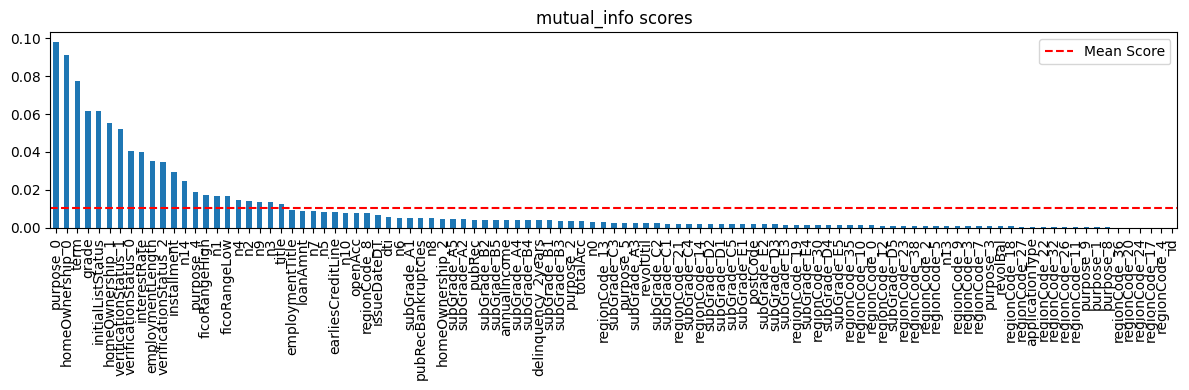

In [38]:
X = data_train.drop(columns=['isDefault'])
y = data_train['isDefault']

X = prepare_features_for_selection(X)

X_new, selected_cols, selected_cols_relaxed= feature_selection_pipeline(X, y, var_thresh=0.01)

In [39]:
X_new

,purpose_0,homeOwnership_0,term,grade,initialListStatus,homeOwnership_1,verificationStatus_1,verificationStatus_0,interestRate,employmentLength,...,n14,purpose_4,ficoRangeHigh,n1,ficoRangeLow,n4,n2,n9,n3,title
0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,19.52,2.0,...,2.0,0.0,734.0,2.0,730.0,4.0,2.0,2.0,2.0,1.0
1,1.0,1.0,5.0,4.0,1.0,0.0,0.0,0.0,18.49,5.0,...,2.0,0.0,704.0,3.0,700.0,10.0,5.0,5.0,5.0,6326.0
2,1.0,1.0,5.0,4.0,0.0,0.0,0.0,0.0,16.99,8.0,...,4.0,0.0,679.0,0.0,675.0,0.0,3.0,3.0,3.0,0.0
3,0.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,7.26,10.0,...,1.0,1.0,689.0,4.0,685.0,4.0,6.0,6.0,6.0,26200.0
4,0.0,0.0,3.0,3.0,0.0,1.0,0.0,0.0,12.99,10.0,...,4.0,0.0,694.0,2.0,690.0,2.0,7.0,7.0,7.0,910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,1.0,0.0,3.0,3.0,1.0,1.0,0.0,1.0,14.49,7.0,...,3.0,0.0,714.0,5.0,710.0,6.0,10.0,10.0,10.0,0.0
799996,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,7.90,10.0,...,0.0,1.0,724.0,2.0,720.0,2.0,2.0,2.0,2.0,20514.0
799997,1.0,0.0,3.0,3.0,1.0,1.0,0.0,0.0,13.33,10.0,...,4.0,0.0,674.0,1.0,670.0,1.0,4.0,4.0,4.0,0.0
799998,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,6.92,10.0,...,5.0,1.0,679.0,5.0,675.0,7.0,8.0,8.0,8.0,26200.0


In [64]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel

In [ ]:
# If the number of features is still large, consider running the following code for further selection

#l1_model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5)
#l1_model.fit(X_new, y)

#sfm = SelectFromModel(l1_model, prefit=True)
#X_selected = sfm.transform(X_new)

In [40]:
selected_cols

['purpose_0',
 'homeOwnership_0',
 'term',
 'grade',
 'initialListStatus',
 'homeOwnership_1',
 'verificationStatus_1',
 'verificationStatus_0',
 'interestRate',
 'employmentLength',
 'verificationStatus_2',
 'installment',
 'n14',
 'purpose_4',
 'ficoRangeHigh',
 'n1',
 'ficoRangeLow',
 'n4',
 'n2',
 'n9',
 'n3',
 'title']

In [41]:
selected_cols_relaxed

['purpose_0',
 'homeOwnership_0',
 'term',
 'grade',
 'initialListStatus',
 'homeOwnership_1',
 'verificationStatus_1',
 'verificationStatus_0',
 'interestRate',
 'employmentLength',
 'verificationStatus_2',
 'installment',
 'n14',
 'purpose_4',
 'ficoRangeHigh',
 'n1',
 'ficoRangeLow',
 'n4',
 'n2',
 'n9',
 'n3',
 'title',
 'employmentTitle',
 'loanAmnt',
 'n7',
 'n5',
 'earliesCreditLine',
 'n10',
 'openAcc',
 'regionCode_8',
 'issueDateDT',
 'dti',
 'n6',
 'subGrade_A1',
 'pubRecBankruptcies',
 'n8',
 'homeOwnership_2',
 'subGrade_A5',
 'subGrade_A2',
 'pubRec',
 'subGrade_B2',
 'subGrade_B5',
 'annualIncome',
 'subGrade_A4',
 'subGrade_B4',
 'delinquency_2years',
 'subGrade_B1',
 'subGrade_B3',
 'purpose_2',
 'totalAcc',
 'n0',
 'regionCode_13',
 'subGrade_C3',
 'purpose_5',
 'subGrade_A3',
 'revolUtil',
 'subGrade_C2',
 'subGrade_C1',
 'regionCode_21',
 'subGrade_C4',
 'regionCode_14',
 'subGrade_D2',
 'subGrade_D1',
 'subGrade_C5',
 'subGrade_E1',
 'postCode',
 'subGrade_E2',
 's

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier


def cross_validate_model(train_x, train_y, test_x, model_type="lgb", n_splits=5, seed=2020):
    """
    Perform K-Fold cross-validation for LightGBM, XGBoost, or CatBoost models.

    Parameters:
    - train_x (pd.DataFrame): Training features
    - train_y (pd.Series or np.array): Training target
    - test_x (pd.DataFrame): Test features
    - model_type (str): One of 'lgb', 'xgb', 'cat' indicating model type
    - n_splits (int): Number of cross-validation folds
    - seed (int): Random seed for reproducibility

    Returns:
    - oof_preds (np.array): Out-of-fold predictions for training set
    - test_preds (np.array): Averaged predictions for test set
    - scores (list): AUC scores per fold
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof_preds = np.zeros(train_x.shape[0])
    test_preds = np.zeros(test_x.shape[0])
    scores = []

    for i, (train_idx, valid_idx) in enumerate(kf.split(train_x)):
        print(f"\n===== Fold {i+1} / {n_splits} =====")
        X_trn, y_trn = train_x.iloc[train_idx], train_y.iloc[train_idx]
        X_val, y_val = train_x.iloc[valid_idx], train_y.iloc[valid_idx]

        if model_type == "lgb":
            train_data = lgb.Dataset(X_trn, label=y_trn)
            valid_data = lgb.Dataset(X_val, label=y_val)
            params = {
                'objective': 'binary',
                'metric': 'auc',
                'learning_rate': 0.05,
                'num_leaves': 31,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'lambda_l2': 10,
                'seed': seed,
                'verbose': -1,
            }
            model = lgb.train(params, train_data, valid_sets=[train_data, valid_data],
                              num_boost_round=10000, callbacks=[lgb.early_stopping(stopping_rounds=200),
                                                                lgb.log_evaluation(period=200)])
            val_pred = model.predict(X_val, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)

        elif model_type == "xgb":
            train_data = xgb.DMatrix(X_trn, label=y_trn)
            valid_data = xgb.DMatrix(X_val, label=y_val)
            test_data = xgb.DMatrix(test_x)
            params = {
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'eta': 0.05,
                'max_depth': 5,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'lambda': 10,
                'seed': seed,
                'verbosity': 0
            }
            model = xgb.train(params, train_data, num_boost_round=10000,
                              evals=[(train_data, 'train'), (valid_data, 'valid')],
                              early_stopping_rounds=200, verbose_eval=200)
            val_pred = model.predict(valid_data, iteration_range=(0, model.best_iteration + 1))
            test_pred = model.predict(test_data, iteration_range=(0, model.best_iteration + 1))

        elif model_type == "cat":
            model = CatBoostClassifier(
                iterations=10000,
                learning_rate=0.05,
                depth=5,
                l2_leaf_reg=10,
                eval_metric='AUC',
                random_seed=seed,
                od_type='Iter',
                od_wait=200,
                verbose=200
            )
            model.fit(X_trn, y_trn, eval_set=(X_val, y_val), use_best_model=True)
            val_pred = model.predict_proba(X_val)[:, 1]
            test_pred = model.predict_proba(test_x)[:, 1]

        else:
            raise ValueError("Invalid model_type. Choose from 'lgb', 'xgb', or 'cat'.")

        oof_preds[valid_idx] = val_pred
        test_preds += test_pred / n_splits
        auc = roc_auc_score(y_val, val_pred)
        scores.append(auc)
        print(f"AUC for fold {i+1}: {auc:.6f}")

    print(f"\nMean AUC: {np.mean(scores):.6f} | Std: {np.std(scores):.6f}")
    return oof_preds, test_preds, scores

In [43]:
test_x = data_testA[selected_cols]

In [44]:
test_x

,purpose_0,homeOwnership_0,term,grade,initialListStatus,homeOwnership_1,verificationStatus_1,verificationStatus_0,interestRate,employmentLength,...,n14,purpose_4,ficoRangeHigh,n1,ficoRangeLow,n4,n2,n9,n3,title
0,True,True,3,2,0,False,False,True,10.99,10,...,3.0,False,719.0,4.0,715.0,6.0,6.0,6.0,6.0,0
1,False,True,5,3,0,False,False,True,14.65,10,...,2.0,False,674.0,1.0,670.0,1.0,3.0,3.0,3.0,34699
2,True,False,3,4,1,True,False,False,19.99,2,...,7.0,False,714.0,1.0,710.0,1.0,4.0,4.0,4.0,0
3,False,True,5,3,0,False,True,False,14.31,4,...,3.0,True,689.0,2.0,685.0,4.0,2.0,2.0,2.0,26200
4,True,False,3,4,0,True,True,False,17.09,0,...,1.0,False,689.0,8.0,685.0,9.0,11.0,11.0,11.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,False,False,3,2,1,True,False,False,11.14,7,...,4.0,True,689.0,2.0,685.0,2.0,2.0,2.0,2.0,36938
199996,True,False,3,1,0,True,False,True,6.24,1,...,0.0,False,724.0,5.0,720.0,5.0,6.0,6.0,6.0,0
199997,False,False,5,3,0,False,False,False,15.88,8,...,0.0,True,679.0,7.0,675.0,9.0,13.0,13.0,13.0,26200
199998,True,False,3,4,0,True,False,True,18.06,4,...,2.0,False,694.0,3.0,690.0,4.0,6.0,6.0,6.0,0


In [45]:
bool_cols = test_x.select_dtypes(include=['bool']).columns
test_x[bool_cols] = test_x[bool_cols].astype(int)

In [46]:
test_x

,purpose_0,homeOwnership_0,term,grade,initialListStatus,homeOwnership_1,verificationStatus_1,verificationStatus_0,interestRate,employmentLength,...,n14,purpose_4,ficoRangeHigh,n1,ficoRangeLow,n4,n2,n9,n3,title
0,1,1,3,2,0,0,0,1,10.99,10,...,3.0,0,719.0,4.0,715.0,6.0,6.0,6.0,6.0,0
1,0,1,5,3,0,0,0,1,14.65,10,...,2.0,0,674.0,1.0,670.0,1.0,3.0,3.0,3.0,34699
2,1,0,3,4,1,1,0,0,19.99,2,...,7.0,0,714.0,1.0,710.0,1.0,4.0,4.0,4.0,0
3,0,1,5,3,0,0,1,0,14.31,4,...,3.0,1,689.0,2.0,685.0,4.0,2.0,2.0,2.0,26200
4,1,0,3,4,0,1,1,0,17.09,0,...,1.0,0,689.0,8.0,685.0,9.0,11.0,11.0,11.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,0,3,2,1,1,0,0,11.14,7,...,4.0,1,689.0,2.0,685.0,2.0,2.0,2.0,2.0,36938
199996,1,0,3,1,0,1,0,1,6.24,1,...,0.0,0,724.0,5.0,720.0,5.0,6.0,6.0,6.0,0
199997,0,0,5,3,0,0,0,0,15.88,8,...,0.0,1,679.0,7.0,675.0,9.0,13.0,13.0,13.0,26200
199998,1,0,3,4,0,1,0,1,18.06,4,...,2.0,0,694.0,3.0,690.0,4.0,6.0,6.0,6.0,0


In [50]:
X_new

In [51]:
test_x.shape

(200000, 22)

In [52]:
X_new.shape

(800000, 22)

In [53]:
oof_preds_lgb, test_preds_lgb, scores_lgb = cross_validate_model(X_new, y, test_x=test_x, model_type="lgb")


===== Fold 1 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.716598	valid_1's auc: 0.71363
[400]	training's auc: 0.721259	valid_1's auc: 0.714446
[600]	training's auc: 0.725519	valid_1's auc: 0.714975
[800]	training's auc: 0.72936	valid_1's auc: 0.71506
Early stopping, best iteration is:
[654]	training's auc: 0.726614	valid_1's auc: 0.715105
AUC for fold 1: 0.715105

===== Fold 2 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.717847	valid_1's auc: 0.708604
[400]	training's auc: 0.722704	valid_1's auc: 0.709403
[600]	training's auc: 0.726709	valid_1's auc: 0.709784
[800]	training's auc: 0.730295	valid_1's auc: 0.709854
[1000]	training's auc: 0.73361	valid_1's auc: 0.709953
[1200]	training's auc: 0.736784	valid_1's auc: 0.709931
Early stopping, best iteration is:
[1024]	training's auc: 0.734062	valid_1's auc: 0.709976
AUC for fold 2: 0.709976

===== Fold 3 / 5 =====
Training until validation

In [54]:
oof_preds_xgb, test_preds_xgb, scores_xgb = cross_validate_model(X_new, y, test_x=test_x, model_type="xgb")


===== Fold 1 / 5 =====
[0]	train-auc:0.69654	valid-auc:0.69759
[200]	train-auc:0.71514	valid-auc:0.71332
[400]	train-auc:0.71935	valid-auc:0.71458
[600]	train-auc:0.72255	valid-auc:0.71495
[800]	train-auc:0.72524	valid-auc:0.71511
[1000]	train-auc:0.72774	valid-auc:0.71515
[1167]	train-auc:0.72960	valid-auc:0.71506
AUC for fold 1: 0.715180

===== Fold 2 / 5 =====
[0]	train-auc:0.69848	valid-auc:0.69402
[200]	train-auc:0.71644	valid-auc:0.70829
[400]	train-auc:0.72056	valid-auc:0.70946
[600]	train-auc:0.72377	valid-auc:0.70987
[800]	train-auc:0.72634	valid-auc:0.71010
[1000]	train-auc:0.72881	valid-auc:0.71021
[1200]	train-auc:0.73094	valid-auc:0.71024
[1400]	train-auc:0.73297	valid-auc:0.71015
[1403]	train-auc:0.73301	valid-auc:0.71015
AUC for fold 2: 0.710258

===== Fold 3 / 5 =====
[0]	train-auc:0.69689	valid-auc:0.69843
[200]	train-auc:0.71524	valid-auc:0.71244
[400]	train-auc:0.71962	valid-auc:0.71378
[600]	train-auc:0.72274	valid-auc:0.71428
[800]	train-auc:0.72547	valid-auc:0.71

In [55]:
oof_preds_cat, test_preds_cat, scores_cat = cross_validate_model(X_new, y, test_x=test_x, model_type="cat")


===== Fold 1 / 5 =====
0:	test: 0.6943456	best: 0.6943456 (0)	total: 101ms	remaining: 16m 54s
200:	test: 0.7110522	best: 0.7110522 (200)	total: 5.67s	remaining: 4m 36s
400:	test: 0.7129520	best: 0.7129520 (400)	total: 11.5s	remaining: 4m 35s
600:	test: 0.7138847	best: 0.7138847 (600)	total: 17.4s	remaining: 4m 31s
800:	test: 0.7144089	best: 0.7144092 (799)	total: 23s	remaining: 4m 24s
1000:	test: 0.7147642	best: 0.7147648 (999)	total: 28.8s	remaining: 4m 19s
1200:	test: 0.7150060	best: 0.7150096 (1198)	total: 34.7s	remaining: 4m 14s
1400:	test: 0.7151684	best: 0.7151700 (1399)	total: 40.5s	remaining: 4m 8s
1600:	test: 0.7152959	best: 0.7153078 (1573)	total: 46.3s	remaining: 4m 2s
1800:	test: 0.7153902	best: 0.7153902 (1800)	total: 51.9s	remaining: 3m 56s
2000:	test: 0.7154826	best: 0.7154826 (2000)	total: 57.6s	remaining: 3m 50s
2200:	test: 0.7155362	best: 0.7155362 (2200)	total: 1m 3s	remaining: 3m 44s
2400:	test: 0.7154970	best: 0.7155362 (2200)	total: 1m 9s	remaining: 3m 39s
Stoppe

In [56]:
test_preds_cat

array([0.0994081 , 0.24680281, 0.41279575, ..., 0.39913497, 0.30542868,
       0.03740537])

In [57]:
# 获取所有 _outlier_flag 列
outlier_cols = [col for col in result_df.columns if col.endswith('_outlier_flag')]

# 计算每行是否有异常值
outlier_mask = result_df[outlier_cols].sum(axis=1) == 0

# 只保留正常值行
data_cleaned = result_df[outlier_mask].copy()
y_cleaned = y[outlier_mask]

In [58]:
bool_cols = data_cleaned.select_dtypes(include=['bool']).columns
data_cleaned[bool_cols] = data_cleaned[bool_cols].astype(int)

In [59]:
X_cleaned_selected = data_cleaned[selected_cols]

In [60]:
X_cleaned_selected

,purpose_0,homeOwnership_0,term,grade,initialListStatus,homeOwnership_1,verificationStatus_1,verificationStatus_0,interestRate,employmentLength,...,n14,purpose_4,ficoRangeHigh,n1,ficoRangeLow,n4,n2,n9,n3,title
0,0,0,5,5,0,0,0,0,19.52,2,...,2.0,0,734.0,2.0,730.0,4.0,2.0,2.0,2.0,1.0
1,1,1,5,4,1,0,0,0,18.49,5,...,2.0,0,704.0,3.0,700.0,10.0,5.0,5.0,5.0,1723.0
2,1,1,5,4,0,0,0,0,16.99,8,...,4.0,0,679.0,0.0,675.0,0.0,3.0,3.0,3.0,0.0
4,0,0,3,3,0,1,0,0,12.99,10,...,4.0,0,694.0,2.0,690.0,2.0,7.0,7.0,7.0,11.0
6,1,1,3,1,0,0,0,1,7.69,9,...,3.0,0,759.0,1.0,755.0,7.0,3.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799994,1,1,5,5,0,0,0,0,19.52,7,...,6.0,0,679.0,3.0,675.0,3.0,4.0,4.0,4.0,0.0
799995,1,0,3,3,1,1,0,1,14.49,7,...,3.0,0,714.0,5.0,710.0,6.0,10.0,10.0,10.0,0.0
799997,1,0,3,3,1,1,0,0,13.33,10,...,4.0,0,674.0,1.0,670.0,1.0,4.0,4.0,4.0,0.0
799998,0,1,3,1,1,0,0,0,6.92,10,...,5.0,1,679.0,5.0,675.0,7.0,8.0,8.0,8.0,4.0


In [61]:
y_cleaned

0         1
1         0
2         0
4         0
6         0
         ..
799994    1
799995    0
799997    1
799998    0
799999    0
Name: isDefault, Length: 637893, dtype: int64

In [62]:
oof_preds_cs_lgb, test_preds_cs_lgb, scores_cs_lgb = cross_validate_model(X_cleaned_selected, y_cleaned, test_x=test_x, model_type="lgb")


===== Fold 1 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.714937	valid_1's auc: 0.711241
[400]	training's auc: 0.720572	valid_1's auc: 0.712196
[600]	training's auc: 0.725295	valid_1's auc: 0.712454
[800]	training's auc: 0.729887	valid_1's auc: 0.712546
[1000]	training's auc: 0.734132	valid_1's auc: 0.712667
Early stopping, best iteration is:
[987]	training's auc: 0.733835	valid_1's auc: 0.712695
AUC for fold 1: 0.712695

===== Fold 2 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.715814	valid_1's auc: 0.706454
[400]	training's auc: 0.721729	valid_1's auc: 0.707192
[600]	training's auc: 0.72665	valid_1's auc: 0.707073
Early stopping, best iteration is:
[430]	training's auc: 0.72245	valid_1's auc: 0.707292
AUC for fold 2: 0.707292

===== Fold 3 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.715256	valid_1's auc: 0.708446
[400]	training's a

In [63]:
oof_preds_cs_xgb, test_preds_cs_xgb, scores_cs_xgb = cross_validate_model(X_cleaned_selected, y_cleaned, test_x=test_x, model_type="xgb")


===== Fold 1 / 5 =====
[0]	train-auc:0.69430	valid-auc:0.69621
[200]	train-auc:0.71329	valid-auc:0.71087
[400]	train-auc:0.71791	valid-auc:0.71195
[600]	train-auc:0.72175	valid-auc:0.71228
[800]	train-auc:0.72508	valid-auc:0.71236
[1000]	train-auc:0.72815	valid-auc:0.71232
[1097]	train-auc:0.72950	valid-auc:0.71227
AUC for fold 1: 0.712428

===== Fold 2 / 5 =====
[0]	train-auc:0.69555	valid-auc:0.69204
[200]	train-auc:0.71458	valid-auc:0.70615
[400]	train-auc:0.71930	valid-auc:0.70687
[600]	train-auc:0.72303	valid-auc:0.70703
[800]	train-auc:0.72628	valid-auc:0.70697
[836]	train-auc:0.72682	valid-auc:0.70694
AUC for fold 2: 0.707074

===== Fold 3 / 5 =====
[0]	train-auc:0.69505	valid-auc:0.69375
[200]	train-auc:0.71403	valid-auc:0.70832
[400]	train-auc:0.71887	valid-auc:0.70899
[600]	train-auc:0.72281	valid-auc:0.70917
[762]	train-auc:0.72547	valid-auc:0.70903
AUC for fold 3: 0.709188

===== Fold 4 / 5 =====
[0]	train-auc:0.69495	valid-auc:0.69407
[200]	train-auc:0.71380	valid-auc:0.7

In [64]:
oof_preds_cs_cat, test_preds_cs_cat, scores_cs_cat = cross_validate_model(X_cleaned_selected, y_cleaned, test_x=test_x, model_type="cat")


===== Fold 1 / 5 =====
0:	test: 0.6834954	best: 0.6834954 (0)	total: 29.1ms	remaining: 4m 51s
200:	test: 0.7090725	best: 0.7090725 (200)	total: 5.16s	remaining: 4m 11s
400:	test: 0.7105856	best: 0.7105875 (399)	total: 10.5s	remaining: 4m 10s
600:	test: 0.7114211	best: 0.7114255 (595)	total: 15.6s	remaining: 4m 3s
800:	test: 0.7118551	best: 0.7118590 (799)	total: 20.7s	remaining: 3m 57s
1000:	test: 0.7120875	best: 0.7120893 (999)	total: 25.9s	remaining: 3m 52s
1200:	test: 0.7122202	best: 0.7122262 (1177)	total: 30.8s	remaining: 3m 46s
1400:	test: 0.7123135	best: 0.7123146 (1372)	total: 35.8s	remaining: 3m 39s
1600:	test: 0.7124452	best: 0.7124527 (1591)	total: 40.9s	remaining: 3m 34s
1800:	test: 0.7124780	best: 0.7125077 (1662)	total: 45.7s	remaining: 3m 28s
2000:	test: 0.7124870	best: 0.7125322 (1887)	total: 50.7s	remaining: 3m 22s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7125322104
bestIteration = 1887

Shrink model to first 1888 iterations.
AUC for fold 1

In [65]:
data_testA.shape

(200000, 152)

In [66]:
data_cleaned.shape

(637893, 185)

In [67]:
X_cleaned2 = data_train[outlier_mask]
X_cleaned2.shape

(637893, 152)

In [68]:
for df in [X_cleaned2, data_testA]:
    df.drop(['issueDate', 'id'], axis=1, inplace=True)

In [69]:
oof_preds_c_lgb, test_preds_c_lgb, scores_c_lgb = cross_validate_model(X_cleaned2, y_cleaned, test_x=data_testA, model_type="lgb")


===== Fold 1 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
AUC for fold 1: 1.000000

===== Fold 2 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
AUC for fold 2: 1.000000

===== Fold 3 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
AUC for fold 3: 1.000000

===== Fold 4 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 1	valid_1's auc: 1
AUC for fold 4: 1.000000

===== Fold 5 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	trai

In [70]:
oof_preds_c_xgb, test_preds_c_xgb, scores_c_xgb = cross_validate_model(X_cleaned2, y_cleaned, test_x=data_testA, model_type="xgb")


===== Fold 1 / 5 =====
[0]	train-auc:1.00000	valid-auc:1.00000
[199]	train-auc:1.00000	valid-auc:1.00000
AUC for fold 1: 1.000000

===== Fold 2 / 5 =====
[0]	train-auc:1.00000	valid-auc:1.00000
[199]	train-auc:1.00000	valid-auc:1.00000
AUC for fold 2: 1.000000

===== Fold 3 / 5 =====
[0]	train-auc:1.00000	valid-auc:1.00000
[200]	train-auc:1.00000	valid-auc:1.00000
AUC for fold 3: 1.000000

===== Fold 4 / 5 =====
[0]	train-auc:1.00000	valid-auc:1.00000
[199]	train-auc:1.00000	valid-auc:1.00000
AUC for fold 4: 1.000000

===== Fold 5 / 5 =====
[0]	train-auc:1.00000	valid-auc:1.00000
[200]	train-auc:1.00000	valid-auc:1.00000
AUC for fold 5: 1.000000

Mean AUC: 1.000000 | Std: 0.000000


In [71]:
oof_preds_c_cat, test_preds_c_cat, scores_c_cat = cross_validate_model(X_cleaned2, y_cleaned, test_x=data_testA, model_type="cat")


===== Fold 1 / 5 =====
0:	test: 1.0000000	best: 1.0000000 (0)	total: 27.9ms	remaining: 4m 38s
200:	test: 1.0000000	best: 1.0000000 (0)	total: 5.23s	remaining: 4m 14s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 1
bestIteration = 0

Shrink model to first 1 iterations.
AUC for fold 1: 1.000000

===== Fold 2 / 5 =====
0:	test: 1.0000000	best: 1.0000000 (0)	total: 25.2ms	remaining: 4m 12s
200:	test: 1.0000000	best: 1.0000000 (0)	total: 5.32s	remaining: 4m 19s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 1
bestIteration = 0

Shrink model to first 1 iterations.
AUC for fold 2: 1.000000

===== Fold 3 / 5 =====
0:	test: 1.0000000	best: 1.0000000 (0)	total: 36.6ms	remaining: 6m 6s
200:	test: 1.0000000	best: 1.0000000 (0)	total: 5.1s	remaining: 4m 8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 1
bestIteration = 0

Shrink model to first 1 iterations.
AUC for fold 3: 1.000000

===== Fold 4 / 5 =====
0:	test: 1.0000000	best: 1.0000

In [72]:
train_original = pd.read_csv('train.csv')
test_original = pd.read_csv('testA.csv')

In [73]:
for df in [train_original, test_original]:
    df['employmentLength'] = df['employmentLength'].astype(str).str.strip()
    df['employmentLength'] = df['employmentLength'].apply(employment_length_to_int)

In [74]:
# Convert issueDate to datetime format
train_original['issueDate'] = pd.to_datetime(train_original['issueDate'], format='%Y-%m-%d')
test_original['issueDate'] = pd.to_datetime(test_original['issueDate'], format='%Y-%m-%d')

# Define a fixed baseline date
base_date = datetime.strptime('2007-06-01', '%Y-%m-%d')

# Create numerical date feature(days since base_date)
train_original['issueDateDT'] = (train_original['issueDate'] - base_date).dt.days
test_original['issueDateDT'] = (test_original['issueDate'] - base_date).dt.days

In [75]:
for df in [train_original, test_original]:
    df['grade'] = df['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

In [76]:
train_original.dtypes

id                             int64
loanAmnt                     float64
term                           int64
interestRate                 float64
installment                  float64
grade                          int64
subGrade                      object
employmentTitle              float64
employmentLength             float64
homeOwnership                  int64
annualIncome                 float64
verificationStatus             int64
issueDate             datetime64[ns]
isDefault                      int64
purpose                        int64
postCode                     float64
regionCode                     int64
dti                          float64
delinquency_2years           float64
ficoRangeLow                 float64
ficoRangeHigh                float64
openAcc                      float64
pubRec                       float64
pubRecBankruptcies           float64
revolBal                     float64
revolUtil                    float64
totalAcc                     float64
i

In [77]:
for df in [train_original, test_original]:
    df['earliesCreditLine'] = df['earliesCreditLine'].apply(extract_year_from_string)

In [78]:
train_original.shape

(800000, 48)

In [79]:
test_original.shape

(200000, 47)

In [80]:
train_original.drop(['isDefault', 'issueDate', 'id'], axis=1, inplace=True)
test_original.drop(['issueDate', 'id'], axis=1, inplace=True)

In [81]:
train_original_selected = train_original[outlier_mask]

In [82]:
train_original_selected, test_original, encoders_dict = label_encode_with_dict(train_original_selected, test_original, ['subGrade'])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.80it/s]


In [83]:
train_original_selected.shape

(637893, 45)

In [84]:
train_original_selected.dtypes

loanAmnt              float64
term                    int64
interestRate          float64
installment           float64
grade                   int64
subGrade                int64
employmentTitle       float64
employmentLength      float64
homeOwnership           int64
annualIncome          float64
verificationStatus      int64
purpose                 int64
postCode              float64
regionCode              int64
dti                   float64
delinquency_2years    float64
ficoRangeLow          float64
ficoRangeHigh         float64
openAcc               float64
pubRec                float64
pubRecBankruptcies    float64
revolBal              float64
revolUtil             float64
totalAcc              float64
initialListStatus       int64
applicationType         int64
earliesCreditLine       int64
title                 float64
policyCode            float64
n0                    float64
n1                    float64
n2                    float64
n3                    float64
n4        

In [85]:
oof_preds_os_lgb, test_preds_os_lgb, scores_os_lgb = cross_validate_model(train_original_selected, 
                                                                          y_cleaned, 
                                                                          test_x=test_original, 
                                                                          model_type="lgb")


===== Fold 1 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.737665	valid_1's auc: 0.732052
[400]	training's auc: 0.747537	valid_1's auc: 0.734585
[600]	training's auc: 0.755474	valid_1's auc: 0.735055
[800]	training's auc: 0.762707	valid_1's auc: 0.735462
[1000]	training's auc: 0.7694	valid_1's auc: 0.735635
[1200]	training's auc: 0.775647	valid_1's auc: 0.735767
[1400]	training's auc: 0.781739	valid_1's auc: 0.7357
Early stopping, best iteration is:
[1280]	training's auc: 0.778002	valid_1's auc: 0.735785
AUC for fold 1: 0.735785

===== Fold 2 / 5 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.738787	valid_1's auc: 0.726928
[400]	training's auc: 0.748585	valid_1's auc: 0.729078
[600]	training's auc: 0.756255	valid_1's auc: 0.72989
[800]	training's auc: 0.763134	valid_1's auc: 0.730499
[1000]	training's auc: 0.769784	valid_1's auc: 0.730825
[1200]	training's auc: 0.776177	valid_1's auc: 0.7309

In [86]:
oof_preds_os_xgb, test_preds_os_xgb, scores_os_xgb = cross_validate_model(train_original_selected, 
                                                                          y_cleaned, 
                                                                          test_x=test_original, 
                                                                          model_type="xgb")


===== Fold 1 / 5 =====
[0]	train-auc:0.69856	valid-auc:0.70096
[200]	train-auc:0.73423	valid-auc:0.73009
[400]	train-auc:0.74352	valid-auc:0.73345
[600]	train-auc:0.75029	valid-auc:0.73467
[800]	train-auc:0.75634	valid-auc:0.73541
[1000]	train-auc:0.76171	valid-auc:0.73582
[1200]	train-auc:0.76688	valid-auc:0.73606
[1400]	train-auc:0.77178	valid-auc:0.73615
[1600]	train-auc:0.77636	valid-auc:0.73611
[1693]	train-auc:0.77840	valid-auc:0.73610
AUC for fold 1: 0.736193

===== Fold 2 / 5 =====
[0]	train-auc:0.70039	valid-auc:0.69541
[200]	train-auc:0.73540	valid-auc:0.72513
[400]	train-auc:0.74437	valid-auc:0.72822
[600]	train-auc:0.75092	valid-auc:0.72973
[800]	train-auc:0.75689	valid-auc:0.73055
[1000]	train-auc:0.76230	valid-auc:0.73089
[1200]	train-auc:0.76722	valid-auc:0.73112
[1400]	train-auc:0.77205	valid-auc:0.73127
[1600]	train-auc:0.77661	valid-auc:0.73132
[1757]	train-auc:0.78005	valid-auc:0.73115
AUC for fold 2: 0.731343

===== Fold 3 / 5 =====
[0]	train-auc:0.69980	valid-auc:

In [87]:
oof_preds_os_cat, test_preds_os_cat, scores_os_cat = cross_validate_model(train_original_selected, 
                                                                          y_cleaned, 
                                                                          test_x=test_original, 
                                                                          model_type="cat")


===== Fold 1 / 5 =====
0:	test: 0.6874486	best: 0.6874486 (0)	total: 29.2ms	remaining: 4m 52s
200:	test: 0.7259979	best: 0.7259979 (200)	total: 5.36s	remaining: 4m 21s
400:	test: 0.7303080	best: 0.7303080 (400)	total: 10.7s	remaining: 4m 16s
600:	test: 0.7321596	best: 0.7321596 (600)	total: 16.4s	remaining: 4m 15s
800:	test: 0.7331671	best: 0.7331671 (800)	total: 22s	remaining: 4m 12s
1000:	test: 0.7338546	best: 0.7338585 (999)	total: 27.8s	remaining: 4m 9s
1200:	test: 0.7344992	best: 0.7344992 (1200)	total: 33.1s	remaining: 4m 2s
1400:	test: 0.7349265	best: 0.7349308 (1395)	total: 38.8s	remaining: 3m 58s
1600:	test: 0.7351870	best: 0.7351890 (1598)	total: 44.2s	remaining: 3m 52s
1800:	test: 0.7353569	best: 0.7353583 (1743)	total: 49.9s	remaining: 3m 47s
2000:	test: 0.7354906	best: 0.7355004 (1986)	total: 55.6s	remaining: 3m 42s
2200:	test: 0.7356717	best: 0.7356768 (2181)	total: 1m 1s	remaining: 3m 36s
2400:	test: 0.7356804	best: 0.7357305 (2297)	total: 1m 6s	remaining: 3m 31s
Stoppe

In [88]:
oof_preds_os_lgb, test_preds_os_lgb, scores_os_lgb = cross_validate_model(train_original_selected, 
                                                                          y_cleaned, 
                                                                          test_x=test_original, 
                                                                          model_type="lgb",
                                                                          n_splits=10)


===== Fold 1 / 10 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.737506	valid_1's auc: 0.729669
[400]	training's auc: 0.746566	valid_1's auc: 0.731955
[600]	training's auc: 0.753734	valid_1's auc: 0.732884
[800]	training's auc: 0.760162	valid_1's auc: 0.73329
[1000]	training's auc: 0.766236	valid_1's auc: 0.733533
[1200]	training's auc: 0.772108	valid_1's auc: 0.733467
Early stopping, best iteration is:
[1008]	training's auc: 0.766527	valid_1's auc: 0.733575
AUC for fold 1: 0.733575

===== Fold 2 / 10 =====
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.736827	valid_1's auc: 0.734919
[400]	training's auc: 0.746092	valid_1's auc: 0.737207
[600]	training's auc: 0.753387	valid_1's auc: 0.738102
[800]	training's auc: 0.760017	valid_1's auc: 0.738499
[1000]	training's auc: 0.766212	valid_1's auc: 0.738812
Early stopping, best iteration is:
[926]	training's auc: 0.764025	valid_1's auc: 0.738829
AUC for fold 

In [89]:
oof_preds_os_xgb, test_preds_os_xgb, scores_os_xgb = cross_validate_model(train_original_selected, 
                                                                          y_cleaned, 
                                                                          test_x=test_original, 
                                                                          model_type="xgb",
                                                                          n_splits=10)


===== Fold 1 / 10 =====
[0]	train-auc:0.69936	valid-auc:0.69848
[200]	train-auc:0.73431	valid-auc:0.72784
[400]	train-auc:0.74291	valid-auc:0.73120
[600]	train-auc:0.74938	valid-auc:0.73260
[800]	train-auc:0.75484	valid-auc:0.73313
[1000]	train-auc:0.75986	valid-auc:0.73348
[1200]	train-auc:0.76471	valid-auc:0.73379
[1400]	train-auc:0.76915	valid-auc:0.73372
[1434]	train-auc:0.76989	valid-auc:0.73373
AUC for fold 1: 0.733814

===== Fold 2 / 10 =====
[0]	train-auc:0.69827	valid-auc:0.70384
[200]	train-auc:0.73361	valid-auc:0.73341
[400]	train-auc:0.74225	valid-auc:0.73662
[600]	train-auc:0.74867	valid-auc:0.73815
[800]	train-auc:0.75428	valid-auc:0.73892
[1000]	train-auc:0.75933	valid-auc:0.73933
[1200]	train-auc:0.76411	valid-auc:0.73966
[1400]	train-auc:0.76856	valid-auc:0.73972
[1449]	train-auc:0.76966	valid-auc:0.73973
AUC for fold 2: 0.739796

===== Fold 3 / 10 =====
[0]	train-auc:0.69967	valid-auc:0.69571
[200]	train-auc:0.73451	valid-auc:0.72560
[400]	train-auc:0.74324	valid-auc

In [90]:
oof_preds_os_cat, test_preds_os_cat, scores_os_cat = cross_validate_model(train_original_selected, 
                                                                          y_cleaned, 
                                                                          test_x=test_original, 
                                                                          model_type="cat",
                                                                          n_splits=10)


===== Fold 1 / 10 =====
0:	test: 0.6839565	best: 0.6839565 (0)	total: 27.8ms	remaining: 4m 37s
200:	test: 0.7236309	best: 0.7236309 (200)	total: 4.84s	remaining: 3m 55s
400:	test: 0.7276687	best: 0.7276687 (400)	total: 9.63s	remaining: 3m 50s
600:	test: 0.7296129	best: 0.7296129 (600)	total: 14.5s	remaining: 3m 46s
800:	test: 0.7306625	best: 0.7306625 (800)	total: 20.5s	remaining: 3m 55s
1000:	test: 0.7314864	best: 0.7314885 (999)	total: 25.5s	remaining: 3m 49s
1200:	test: 0.7321777	best: 0.7321777 (1200)	total: 30.6s	remaining: 3m 43s
1400:	test: 0.7326632	best: 0.7326696 (1396)	total: 35.6s	remaining: 3m 38s
1600:	test: 0.7331361	best: 0.7331361 (1600)	total: 40.6s	remaining: 3m 33s
1800:	test: 0.7335277	best: 0.7335312 (1799)	total: 45.5s	remaining: 3m 27s
2000:	test: 0.7336781	best: 0.7336806 (1999)	total: 50.6s	remaining: 3m 22s
2200:	test: 0.7337453	best: 0.7337505 (2185)	total: 55.6s	remaining: 3m 16s
2400:	test: 0.7338480	best: 0.7338726 (2387)	total: 1m 1s	remaining: 3m 13s
2

In [91]:
X_cleaned_selected.shape

(637893, 22)

In [92]:
train_original_selected.shape

(637893, 45)

In [93]:
y_cleaned.shape

(637893,)

In [94]:
df_cs = pd.concat([X_cleaned_selected, y_cleaned],axis=1)

In [95]:
df_cs.shape

(637893, 23)

In [96]:
df_os = pd.concat([train_original_selected, y_cleaned], axis=1)

In [97]:
df_os

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,isDefault
0,35000.0,5,19.52,917.97,5,21,320.0,2.0,2,110000.0,...,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2587,1
1,18000.0,5,18.49,461.90,4,16,219843.0,5.0,0,46000.0,...,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,1888,0
2,12000.0,5,16.99,298.17,4,17,31698.0,8.0,0,74000.0,...,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,3044,0
4,3000.0,3,12.99,101.07,3,11,54.0,NaN,1,29000.0,...,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,3196,0
6,2050.0,3,7.69,63.95,1,3,180083.0,9.0,0,35000.0,...,10.0,18.0,3.0,12.0,0.0,0.0,0.0,3.0,2679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799994,15000.0,5,19.52,393.42,5,21,29191.0,7.0,0,60000.0,...,5.0,12.0,4.0,9.0,0.0,0.0,0.0,6.0,2679,1
799995,25000.0,3,14.49,860.41,3,13,2659.0,7.0,1,72000.0,...,12.0,13.0,10.0,14.0,0.0,0.0,0.0,3.0,3318,0
799997,6000.0,3,13.33,203.12,3,12,2582.0,10.0,1,65000.0,...,4.0,10.0,4.0,5.0,0.0,0.0,1.0,4.0,3044,1
799998,19200.0,3,6.92,592.14,1,3,151.0,10.0,0,96000.0,...,12.0,22.0,8.0,16.0,0.0,0.0,0.0,5.0,2802,0


In [98]:
df_cs.to_csv('data_train_cs.csv', index=False)

In [99]:
df_os.to_csv('data_train_os.csv', index=False)

In [100]:
test_original.to_csv('data_test_os.csv', index=False)

In [101]:
test_x.to_csv('data_test_cs.csv', index=False)

In [102]:
data_testA = pd.read_csv("testA.csv")
test_ids = data_testA['id']

In [103]:
test_preds_os_cat

array([0.06842794, 0.33054085, 0.54353285, ..., 0.17728589, 0.23512423,
       0.02487915])

In [104]:
submission = pd.DataFrame({
    'id': test_ids,  # 确保这个是你的测试集 ID 列
    'isDefault': test_preds_os_cat
})

submission.to_csv('submission.csv', index=False)